In [ ]:
# some basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_ind
import json
import seaborn as sns
import csv
from statsmodels.stats import diagnostic

# Two additional imports are required; math for the rounding function .ceil(), and scipt.stats for chi2 testing
import math
from scipy.stats import chi2_contingency

In [870]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

In [871]:
# merging movie metadata and TMDB
df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title', how = 'inner')

In [872]:
# cleaning the text of the movies' spoken langauge, countries, and genres attributes
def cleaning_fct(pattern):
    if pd.isna(pattern) or pattern == '{}':
        return None
    else:
        dict = json.loads(pattern)
        pattern = list(dict.values())
        return pattern

df_movies_tmdb['spoken_languages_x'] = df_movies_tmdb['spoken_languages_x'].apply(cleaning_fct)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning_fct)
df_movies_tmdb['genres_x'] = df_movies_tmdb['genres_x'].apply(cleaning_fct)


In [873]:
# duplicate columns have appeared, must drop duplicate with more missing data and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={"spoken_languages_x": "spoken_languages"}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={"genres_x": "genres"}) 
df_movies_tmdb = df_movies_tmdb.drop(['release_date_x'], axis = 1).rename(columns={"release_date_y": "release_date"}) 

In [874]:
# clean missing values in release_date and clean dates to keep the release year only (first four digits of the attribute)
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date'])
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].str[:4].astype(int)

# Statistics on Popularity from the Filmakers POV -> Ignore most of this section

## Further cleaning specifically of df_movies

In [875]:
# copied movies_TMBD cleaning
def cleaning_fct(pattern):
    if pd.isna(pattern) or pattern == '{}':
        return None
    else:
        dict = json.loads(pattern)
        pattern = list(dict.values())
        return pattern

print(f"The original df_movies contains {len(df_movies.index)} movies.")

df_movies['spoken_languages'] = df_movies['spoken_languages'].apply(cleaning_fct)
df_movies['countries'] = df_movies['countries'].apply(cleaning_fct)
df_movies['genres'] = df_movies['genres'].apply(cleaning_fct)

df_movies = df_movies.dropna(subset=['release_date'])
df_movies['release_date'] = df_movies['release_date'].str[:4].astype(int)

# further cleaning of the movies dataset; dropping entries
df_movies = df_movies.drop(['wikipedia_id'], axis = 1)
df_movies = df_movies.drop(['freebase_id'], axis = 1)
df_movies = df_movies.dropna(subset=['genres'])

# further cleaning of the movies dataset; filling cells
df_movies.fillna({"revenue": 0})

print(f"The cleaned df_movies contains {len(df_movies.index)} movies.")

The original df_movies contains 81741 movies.
The cleaned df_movies contains 73077 movies.


## Production frequency of basic movie genres

I wanted to understand what genres a movie can have. I saw that movies can have singular genres given to them or several genres given to them. Define genres that are singular as "basic" genres, and those that have several genres (not necessarily using basic genres as their building blocks) as "complex" genres. Focus in these blocks on analyzing basic film genres with only one country listed as the movie country.

In [876]:
# isolate movies with only one genre assigned = the "basic" genres
df_movies_basic = pd.DataFrame()
df_movies_basic = df_movies[df_movies["genres"].apply(lambda x: len(x) == 1)]

# remove list type of genres
df_movies_basic = df_movies_basic.explode("genres")

Additional cleaning of the basic genres is needed as some are identical but written differently (e.g. "comedy" versus "comedy film").

In [877]:
def clean_genres(s, patterns=[" film", " Film", " movies", " Movies", " movie", " Movie"]):
    for pattern in patterns:
        s = s.replace(pattern, '')
    return s

df_movies_basic.loc[:, "genres"] = df_movies_basic["genres"].apply(lambda d: clean_genres(d))

Additional cleaning of the basic genres dataframe is needed as some movies have no countries listed and some have several countries listed.

In [878]:
df_movies_basic = df_movies_basic.dropna(subset=["countries"])
df_movies_basic = df_movies_basic[df_movies_basic["countries"].apply(lambda x: len(x) == 1)]

# remove list type of countries
df_movies_basic = df_movies_basic.explode("countries")

In [879]:
# identify the basic genres
basic_genres = df_movies_basic["genres"].unique()
print(f"There are {len(basic_genres)} unique basic genres.")

# identify the single countries
countries = df_movies_basic["countries"].unique()
print(f"There are {len(countries)} unique countries.")

There are 138 unique basic genres.
There are 108 unique countries.


<Axes: xlabel='genres', ylabel='countries'>

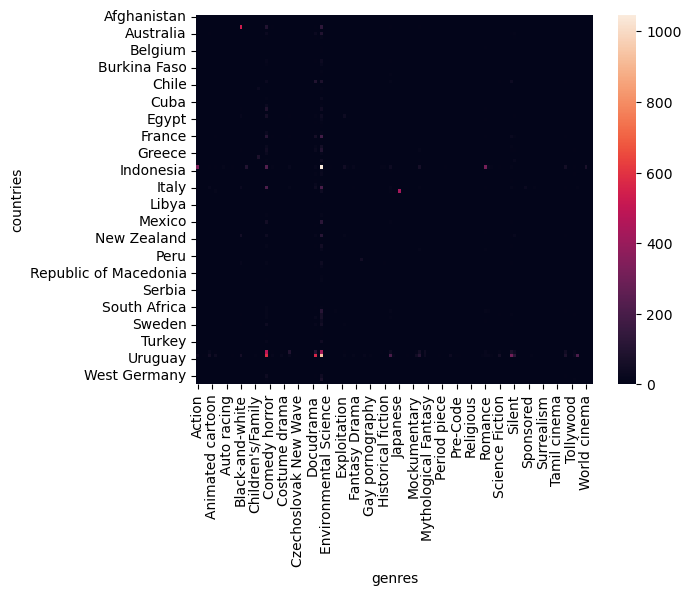

In [880]:
df_basicgenres_singlecountries = pd.crosstab(df_movies_basic['countries'],df_movies_basic['genres'])
sns.heatmap(df_basicgenres_singlecountries, annot=False)

Clearly, there's need to group the countries and maybe reduce the number of genres considered. The grouping of countries will be based on the seven regions we're considering:

Hollywood: United States

Bollywood: India

European: Any country in Europe (excluding the United Kingdom)

East Asian: Countries like China, Japan, South Korea, etc.

Middle Eastern & African: Countries in the Middle East and Africa

Latin America: Countries in Central and South America

United Kingdom: United Kingdom + colonies (Canada, New Zealand, Australia)

In [881]:
# each of the 108 countries are mapped to their regions based on manual mapping saved to a .csv file
df_countries_regional = pd.read_csv(DATA + 'countries_regional.csv')

df_movies_basic = pd.merge(df_movies_basic, df_countries_regional, left_on='countries', right_on='country')
df_movies_basic = df_movies_basic.dropna(subset=['country'])

<Axes: xlabel='genres', ylabel='region'>

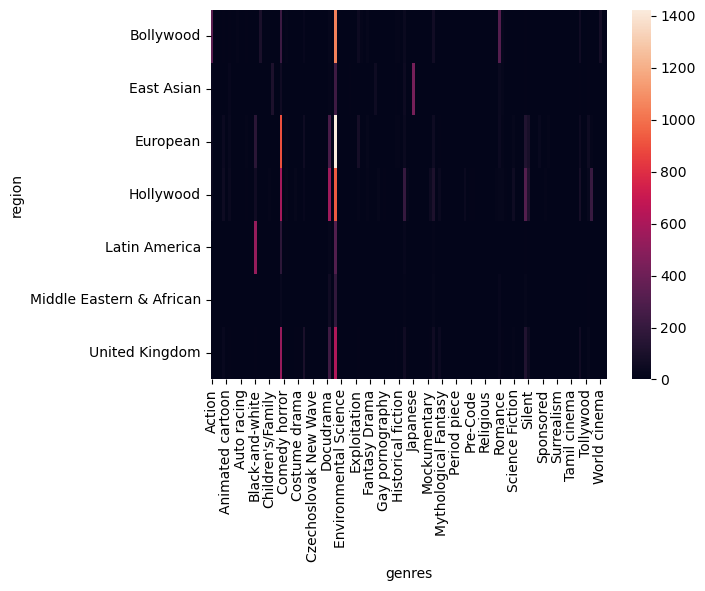

In [882]:
df_basicgenres_regions = pd.crosstab(df_movies_basic['region'],df_movies_basic['genres'])
sns.heatmap(df_basicgenres_regions, annot=False)

Better, but still too many genres. Let's focus to the top 90%, assuming that will give a reasonable number of genres to consider.

In [883]:
basic_genres_counts = df_movies_basic.groupby("genres").size()
basic_genres_counts = basic_genres_counts.sort_values(axis=0, ascending=False)
basic_genres_counts_top = basic_genres_counts.head(20)

top_basicgenres_count = basic_genres_counts_top.sum()
all_basicgenres_count = basic_genres_counts.sum()

print(f"The top 20 basic genres in the movies dataset account for {round(top_basicgenres_count/all_basicgenres_count * 100)}% of all such genres.")

The top 20 basic genres in the movies dataset account for 91% of all such genres.


In [884]:
# the basic genred movies with their regions indicated are filtered to only include films part of the top 20 most recurrent basic genres 
top_basic_genres = basic_genres_counts_top.index.tolist()
df_movies_basic_filtered = df_movies_basic[df_movies_basic["genres"].isin(top_basic_genres)]

<Axes: xlabel='genres', ylabel='region'>

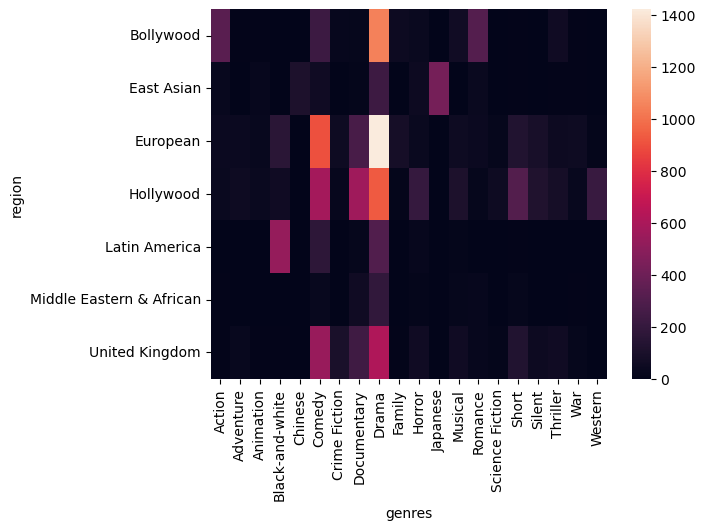

In [885]:
df_basicgenres_top_regions = pd.crosstab(df_movies_basic_filtered['region'],df_movies_basic_filtered['genres'])
sns.heatmap(df_basicgenres_top_regions, annot=False)

Text(0.5, 1.0, 'Top 20 Basic Genres Production Normalized, Across 7 Regions')

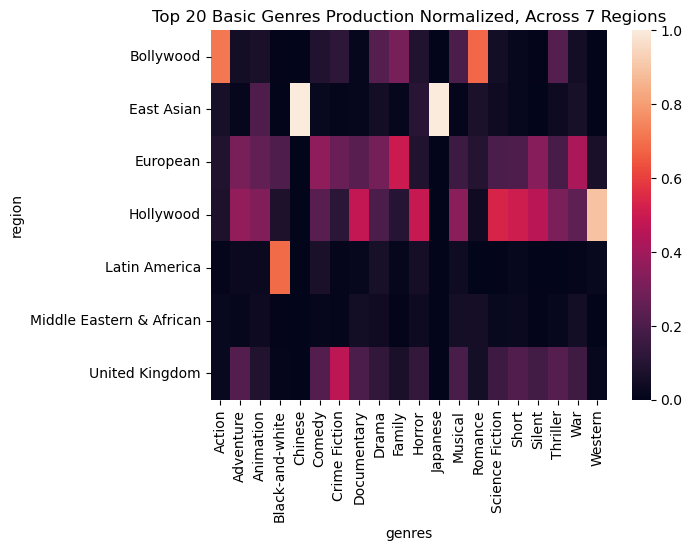

In [945]:
df_basicgenres_top_regions_normalized = pd.crosstab(df_movies_basic_filtered['region'],df_movies_basic_filtered['genres'], normalize='columns')
sns.heatmap(df_basicgenres_top_regions_normalized, annot=False)
plt.title("Top 20 Basic Genres Production Normalized, Across 7 Regions")

## Production frequency of complex movie genres

This block identifies the unique genres a film is given in the movies dataset, when there is more than one genre given to the film. The code also identifies if those complex genres are composed of solely the "basic" genres as building blocks.

In [886]:
# check if movies given more than one genre == the "complex" genres are solely from the list of genres given
df_movies_complex = pd.DataFrame()
df_movies_complex = df_movies[df_movies["genres"].apply(lambda x: len(x) > 1)]

# the complex genres need to be taken out of list formatting
df_movies_complex.loc[:, "genres"] = df_movies_complex["genres"].apply(lambda x: ','.join(x))

# the complex genres building blocks also contain redundancies
df_movies_complex.loc[:, "genres"] = df_movies_complex["genres"].apply(lambda d: clean_genres(d))

# identify the complex genres
complex_genres = df_movies_complex["genres"].unique()
print(f"There are {len(complex_genres)} unique complex genres.")

There are 23087 unique complex genres.


## Film production budgets of basic genres

Taking the budget data from this dataset to see if can use to give new attribute to our movies dataset: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv. Renamed the contained movies_metadata.csv to movies_metadata_budget.csv.


In [887]:
# budget external data loading
budget_cols = ["budget", "title"]
df_budget = pd.read_csv(DATA + 'movies_metadata_budget.csv', sep=',', usecols=budget_cols)
df_budget.columns = ['budget', 'title']

df_movies_basic_budget = pd.merge(df_movies_basic, df_budget, left_on='title', right_on='title')

Only 1965 of our movies dataset have associated budget information from the newly imported budget dataset, and of these only 20% have non-zero budgets. Budget may not be widely available for our movies. Even in the original dataset, only 20% of movies have non-zero budgets reported.

# Popularity statistics from audience POV

## Obtaining movie ratings

Found a potentially useful dataset containing five star ratings on movies here: https://grouplens.org/datasets/movielens/ --> using the 25M dataset at the very bottom of the page; from this, took the movies.csv as ratings_movies.csv, ratings.csv as ratings_ratings.csv, and links.csv as ratings_links.csv.

In [888]:
df_ratings_movies = pd.read_csv(DATA + 'ratings_movies.csv', sep=',')

# remove year from titles
df_ratings_movies["title"] = df_ratings_movies["title"].replace(r"[(].+$", "", regex=True)

# determine how many of these movies match with our movies
df_movies_ratings_combined = pd.merge(df_movies, df_ratings_movies, left_on='title', right_on='title')

Only 53 movies that ratings are given for are in the movies dataset we have from the class. However, not convinced this is true as the ratings dataset has 62'000 movies so surely more than 53 in this dataset exist in our dataset. Attempting a fuzzy merge of the datasets.

In [889]:
#import difflib 

# def fuzzy_merge(df1, df2, left_on, right_on, how='inner', cutoff=0.6):
#     df_other= df2.copy()r
#     df_other[left_on] = [get_closest_match(x, df1[left_on], cutoff) 
#                          for x in df_other[right_on]]
#     return df1.merge(df_other, on=left_on, how=how)

# def get_closest_match(x, other, cutoff):
#     matches = difflib.get_close_matches(x, other, cutoff=cutoff)
#     return matches[0] if matches else None
    
# df_movies_ratings_combined_fuzzy = fuzzy_merge(df_movies, df_ratings_movies,left_on='title', right_on='title')

The above (an attempt at fuzzy merging) is time consuming, realized that the ratings dataset contains a file that has the IMDB and TMDB IDs of the movies in the ratings dataset. Took the IMDB ID of the ratings and merged to the df_movies_tmbd dataframe to see how many of our movies were checked for ratings by this external dataset. Yet, made a new movies and TMDB merged dataframe as the TMDB dataframe contains more than one entry per movie when movies are released in more than one country. This has to be kept in mind but could be useful as now a given movie in our dataset's spread across countries is given.

In [ ]:
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_movies_tmdb_link = df_movies_tmdb

# some films have missing IMDB IDs
df_movies_tmdb_link = df_movies_tmdb_link.dropna(subset=["imdb_id"])
df_movies_tmdb_link = df_movies_tmdb_link.drop(df_movies_tmdb_link[df_movies_tmdb_link["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_TMBD are formatted differently than in df_ratings_link
df_movies_tmdb_link["imdb_id"] = df_movies_tmdb_link["imdb_id"].apply(lambda x: str(x))
df_movies_tmdb_link["imdb_id"] = df_movies_tmdb_link["imdb_id"].apply(lambda x: x.replace("tt", ''))
df_movies_tmdb_link["imdb_id"] = df_movies_tmdb_link["imdb_id"].apply(lambda x: int(x))

Let's quickly see how many movies in our movies_TMDB dataset are given in the ratings dataset.

In [891]:
df_movies_TMDB_ratings = pd.merge(df_movies_tmdb_link, df_ratings_link, left_on='imdb_id', right_on='imdbId')
unique_ratings = len(df_movies_TMDB_ratings["title"].unique())
print(f"There are {unique_ratings} unique movies in our movies dataset that have ratings given by the found dataset.")

There are 26558 unique movies in our movies dataset that have ratings given by the found dataset.


The ratings are needed. Numerous ratings are given per movie. For now, average the ratings per movie. Then, the ratings dataset needs to be merged to the IMDB linker dataset to get the rating per IMDB ID. This assumes the movieID in the ratings dataset matches the same movie as the movieID in the linker dataset, given both came from the same ensemble of data. This final dataset will be merged to the movies_TMDB dataset.

In [892]:
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')
mean_ratings = df_ratings_ratings.groupby(df_ratings_ratings["movieId"]).mean()
mean_ratings = mean_ratings.rename({'rating': 'mean_rating', 'timestamp': 'mean_rating_timestamp'}, axis=1)

# merge the average ratings to their movies in the ratings linker file
df_ratings_linked = pd.merge(df_ratings_link, mean_ratings, left_on='movieId', right_on='movieId')

# now merge the ratings to the movies and TMDB dataset
df_movies_TMDB_ratings = pd.merge(df_movies_tmdb_link, df_ratings_linked, left_on='imdb_id', right_on='imdbId')

This new datatframe needs to be cleaned.

In [ ]:
# keeping wikipedia ID incase we want to merge to characters; dropping many other useless columns
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['freebase_id'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['id'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['status'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['vote_average'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['vote_count'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['backdrop_path'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['budget'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['homepage'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['original_title'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['overview'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['popularity'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['poster_path'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['tagline'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['keywords'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['movieId'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['imdbId'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['tmdbId'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['userId'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['adult'], axis = 1)

# keep metadata from the provided movies dataset source (e.g. CMU datasource)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['revenue_y'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['runtime_y'], axis = 1)

df_movies_TMDB_ratings = df_movies_TMDB_ratings.rename({'revenue_x': 'revenue', 'runtime_x': 'runtime'}, axis=1)

## Describing movie ratings

Wanted to remove outliers from any quantitative column of the original movies dataset, being revenue, runtime, release date.

Text(0, 0.3, 'Number of movies')

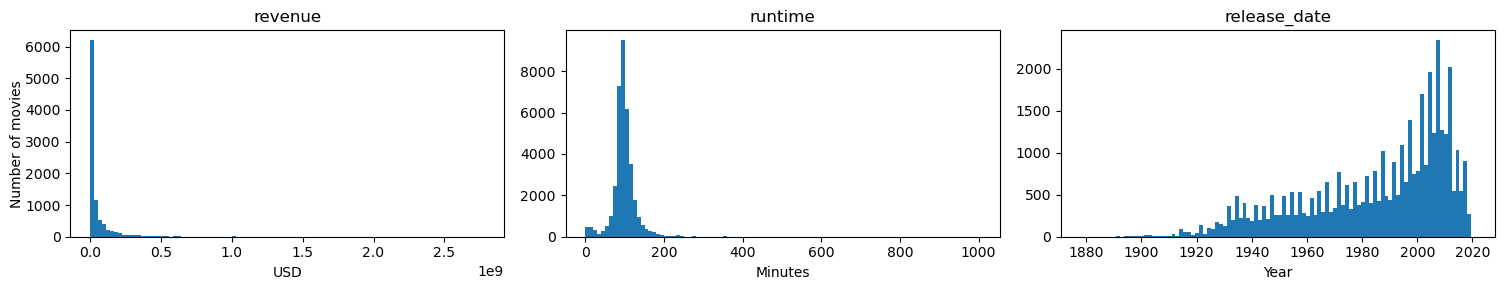

In [894]:
fig, ax = plt.subplots(1,3,figsize= (15,3), sharey = False, sharex = False)

quantities = ['revenue', 'runtime', 'release_date']
quantities_x = ['USD', 'Minutes', 'Year']

for i in range(3):
    sbplt = ax[i]
    sbplt.hist(df_movies_TMDB_ratings[quantities[i]].values, bins = 100)
    sbplt.set_title(quantities[i])
    sbplt.set_xlabel(quantities_x[i])
    
fig.tight_layout()

fig.text(0,0.3, "Number of movies", rotation = 90)

In [895]:
# replace the outliers in the runtime column with mean of non-outliers; assuming normality, apply +/- 1.5*IQR of quantiles method

# calculate IQR for runtime
Q1 = df_movies_TMDB_ratings['runtime'].quantile(0.25)
Q3 = df_movies_TMDB_ratings['runtime'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers versus non-outliers for runtime
threshold = 1.5
runtime_outliers = df_movies_TMDB_ratings[(df_movies_TMDB_ratings['runtime'] < Q1 - threshold * IQR) | (df_movies_TMDB_ratings['runtime'] > Q3 + threshold * IQR)]
df_movies_TMDB_ratings = df_movies_TMDB_ratings[~((df_movies_TMDB_ratings['runtime'] < Q1 - threshold * IQR) | (df_movies_TMDB_ratings['runtime'] > Q3 + threshold * IQR))]

# replace the runtime outliers with the mean of non-runtime outliers
runtime_outliers['runtime'] = df_movies_TMDB_ratings['runtime'].mean()

# put these fixed rows into the original dataframe
df_movies_TMDB_ratings = pd.concat([df_movies_TMDB_ratings, runtime_outliers], ignore_index=True)

In [ ]:
# the below was a failed attempt at proving revenue is an exponential function; failed as NAN values are in the revenue column
diagnostic.kstest_normal(df_movies_TMDB_ratings['revenue'].values, dist = 'exp')

(nan, nan)

Let's begin describing and visualizing mean ratings of movies.

In [897]:
df_movies_TMDB_ratings["mean_rating"].describe()

count    40699.000000
mean         3.090097
std          0.651275
min          0.500000
25%          2.750000
50%          3.166667
75%          3.500000
max          5.000000
Name: mean_rating, dtype: float64

Text(0.5, 1.0, 'Mean Rating of Movies in Movies Metadata File')

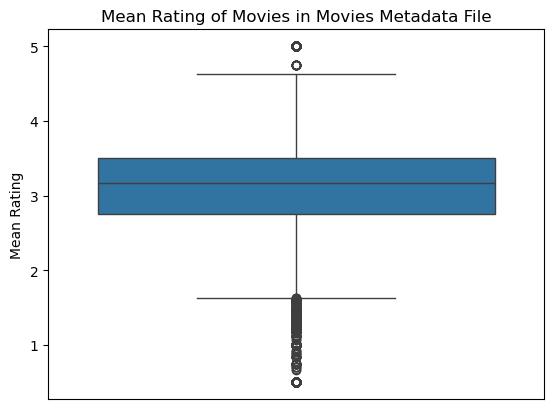

In [898]:
ax = sns.boxplot(data=df_movies_TMDB_ratings['mean_rating'])

plt.xticks([])
plt.ylabel('Mean Rating')
plt.title('Mean Rating of Movies in Movies Metadata File')

Although this boxplot shows outliers, ignore this as none are dramatic/ all within reason.

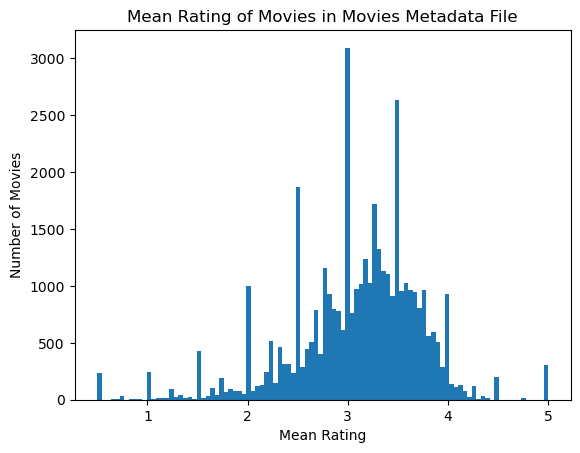

In [899]:
df_movies_TMDB_ratings['mean_rating'].hist(bins = 100)

plt.xlabel('Mean Rating')
plt.ylabel('Number of Movies')
plt.title('Mean Rating of Movies in Movies Metadata File')
plt.grid(False)

Clear spikes at 0.5 values are observed, which makes sense.

In [900]:
diagnostic.kstest_normal(df_movies_TMDB_ratings['mean_rating'].values, dist = 'norm')

(0.09433882614706379, 0.0009999999999998899)

Mean film ratings are normally distributed at a significane level <0.01, which makes sense!

Now try testing relationships between the mean ratings of basic genre movies and other quantitative variables we have about them. 

Text(0.5, 1.0, 'Runtime with Mean Rating of Basic Genre Movie')

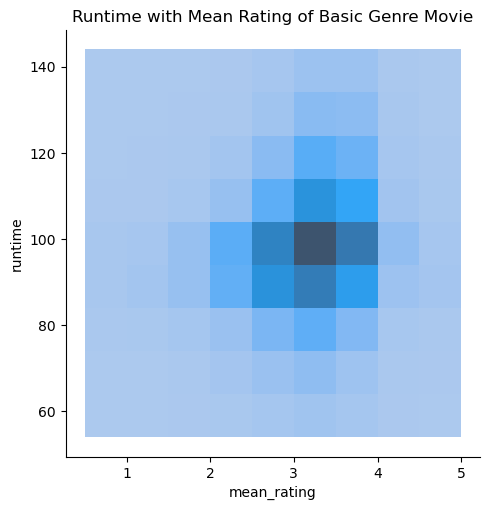

In [943]:
sns.displot(x=df_movies_TMDB_ratings['mean_rating'], y=df_movies_TMDB_ratings['runtime'], binwidth=(0.5, 10))
ax.grid(False)
plt.title("Runtime with Mean Rating of Basic Genre Movie")

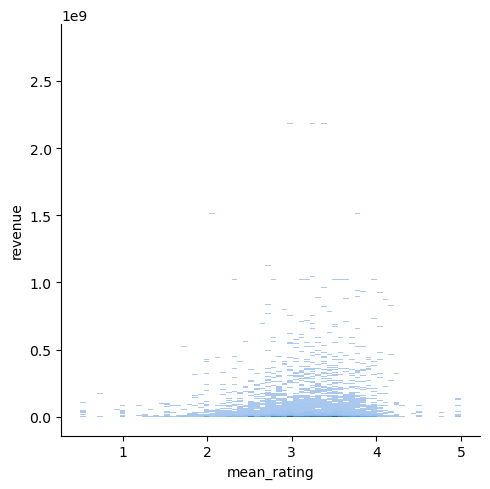

In [ ]:
sns.displot(x=df_movies_TMDB_ratings['mean_rating'], y=df_movies_TMDB_ratings['revenue'])

Feel like outliers should be removed from the above.

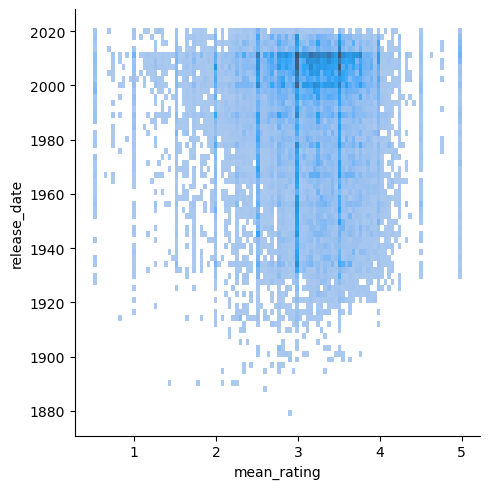

In [903]:
sns.displot(x=df_movies_TMDB_ratings['mean_rating'], y=df_movies_TMDB_ratings['release_date'])

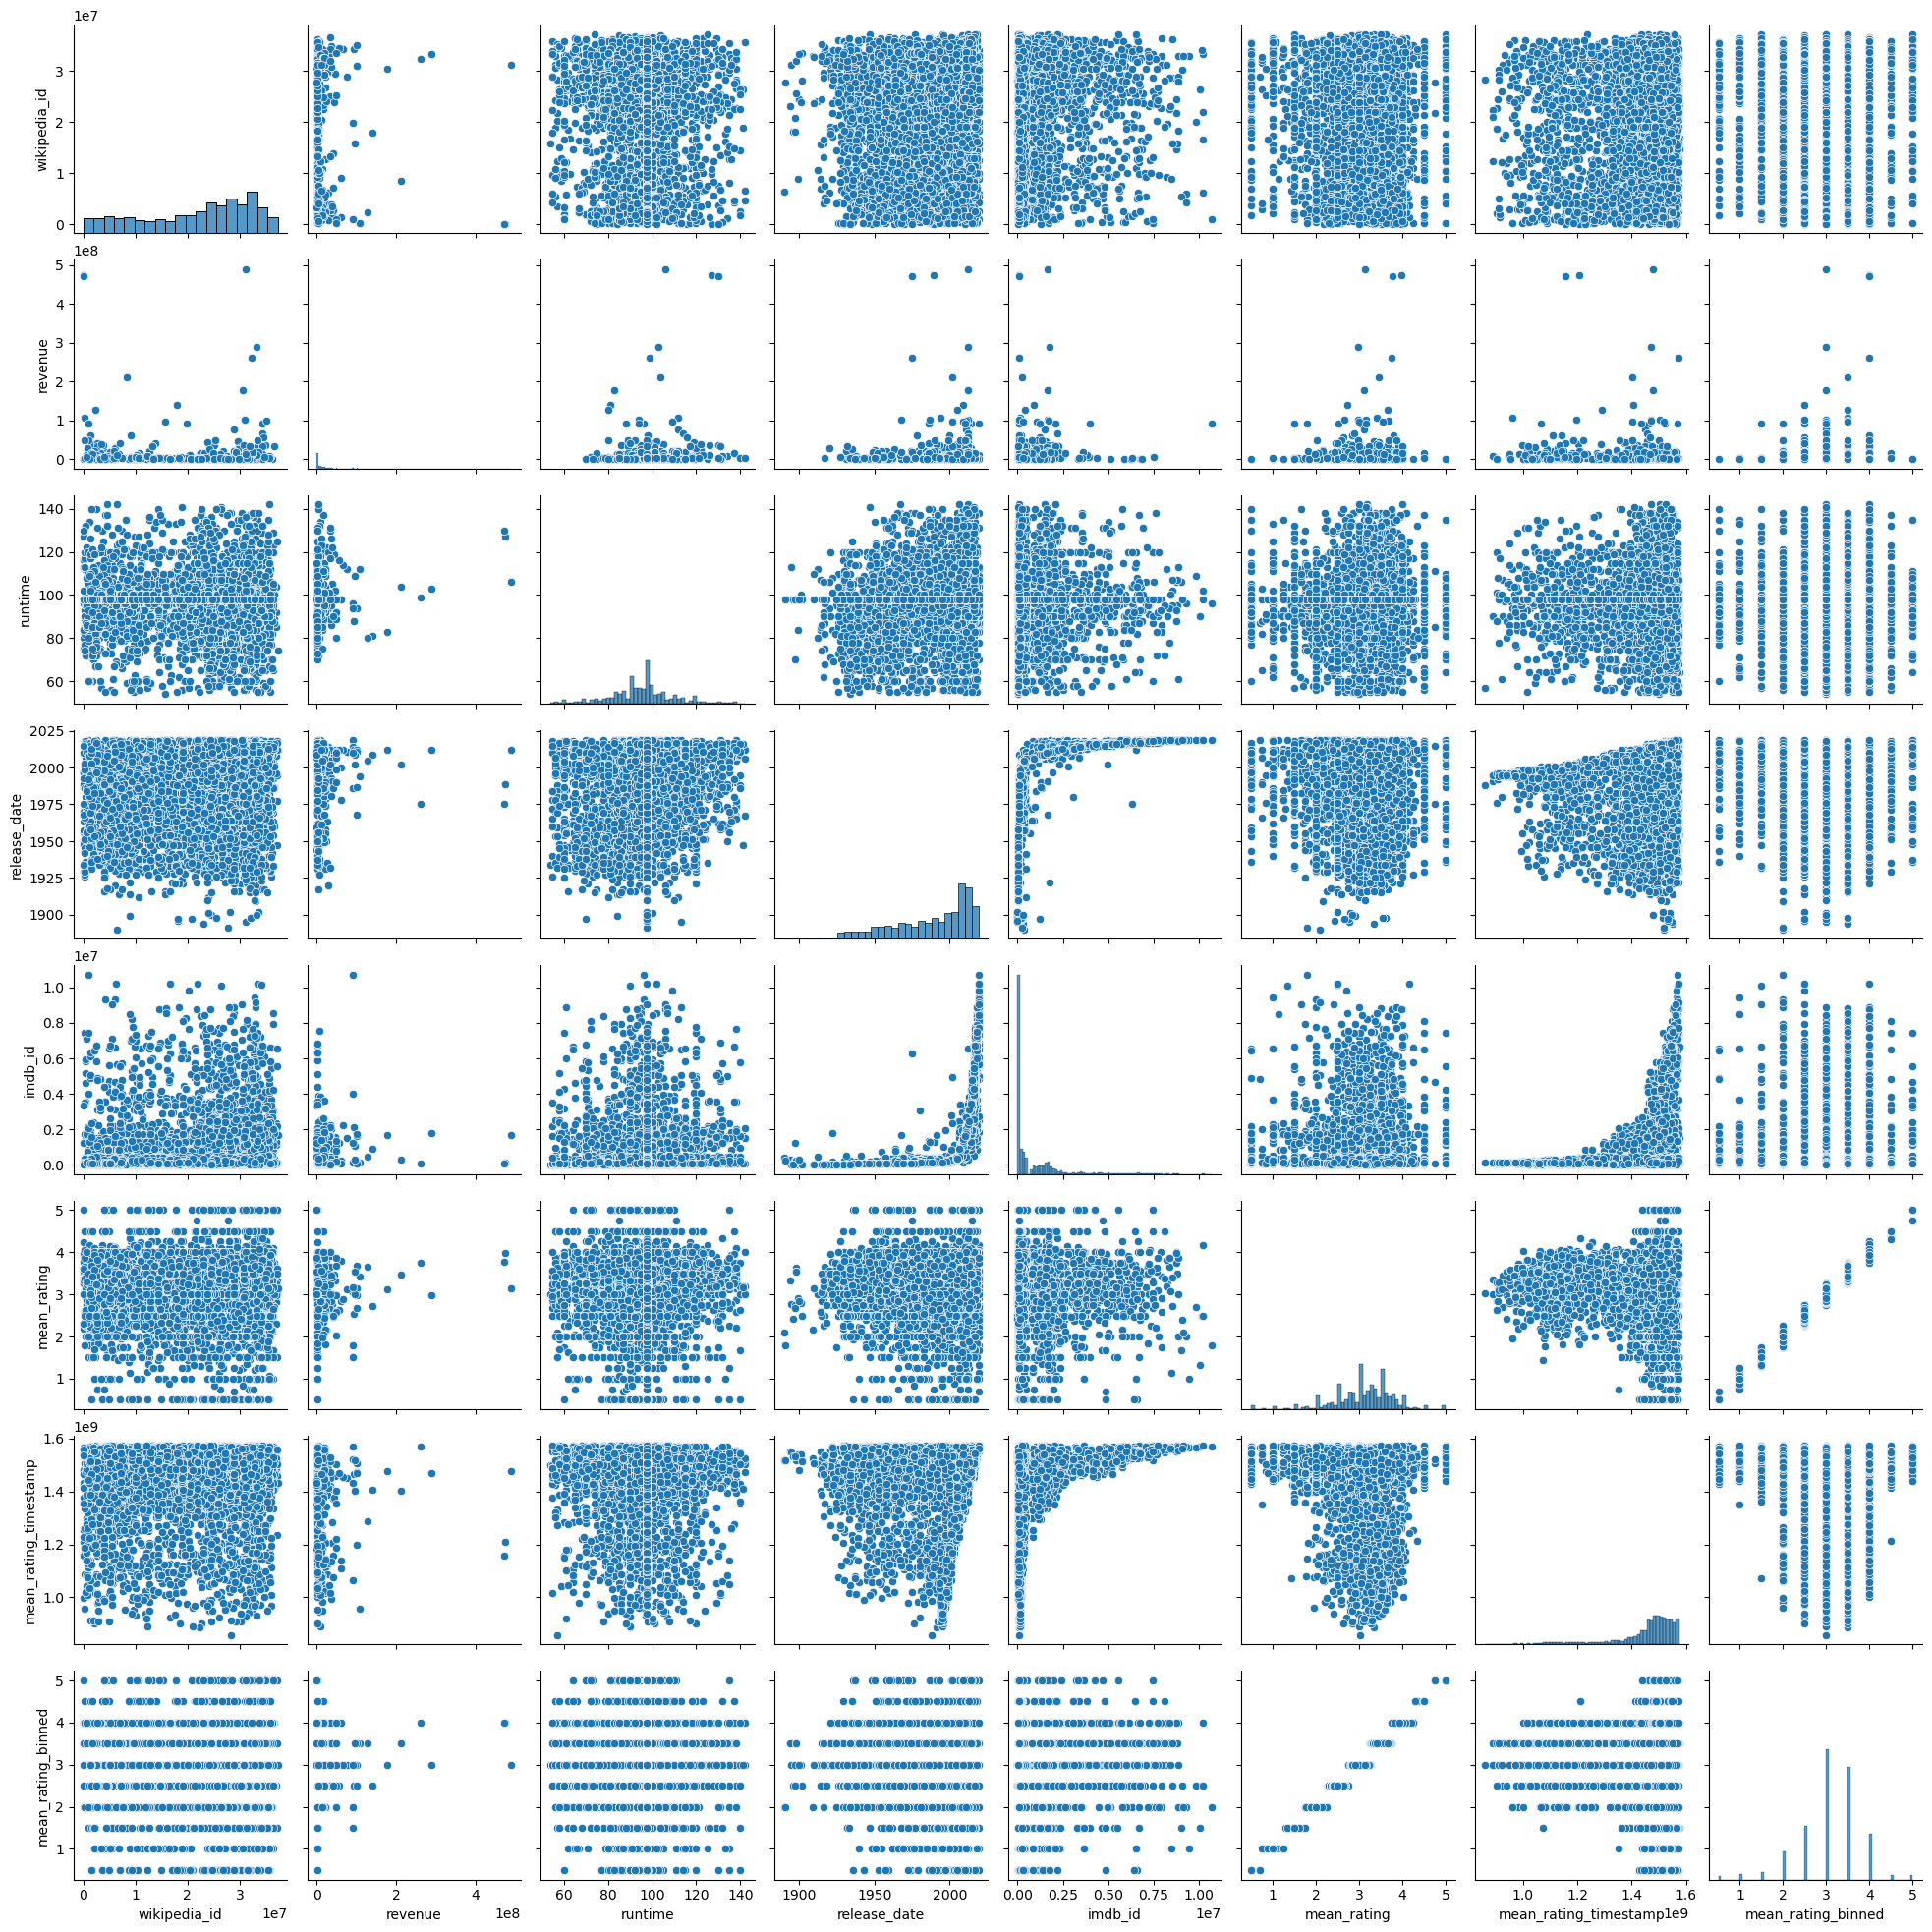

In [933]:
sns.pairplot(df_movies_TMDB_ratings_basic)

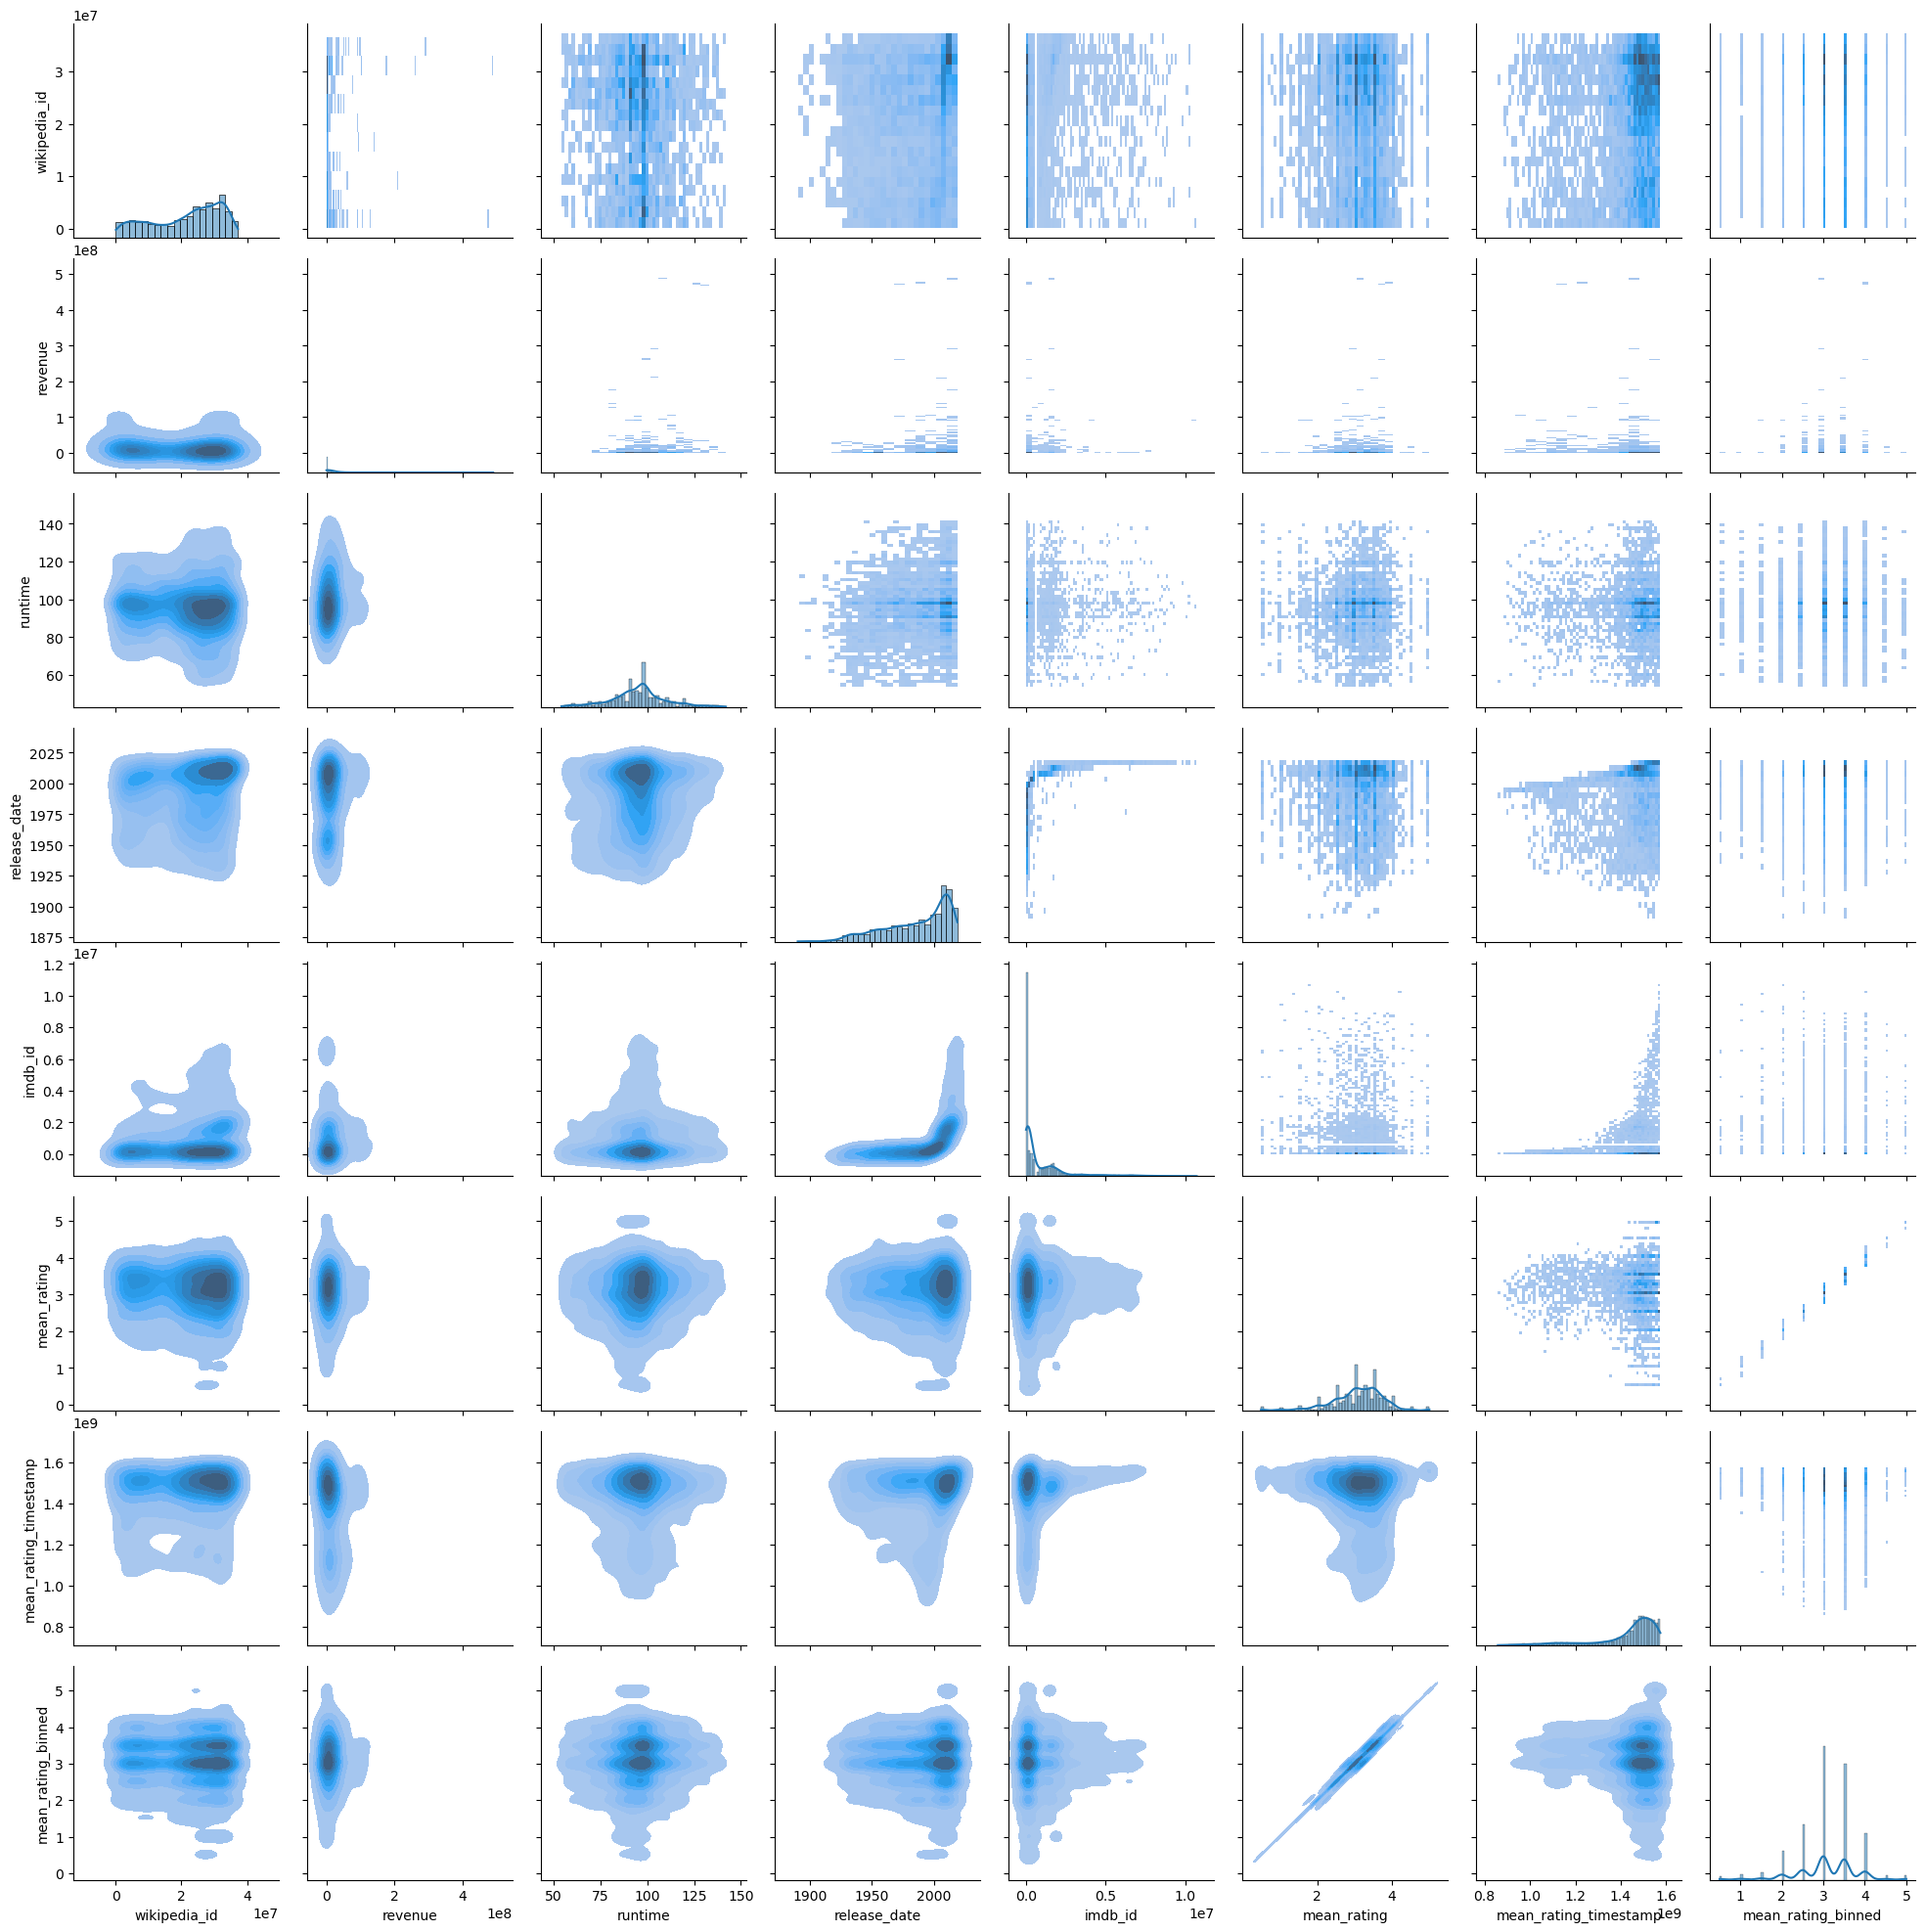

In [934]:
g = sns.PairGrid(df_movies_TMDB_ratings_basic)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

## Mean movie ratings across common basic genres

In [904]:
# remove rows with no genre given
df_movies_TMDB_ratings_filtered = df_movies_TMDB_ratings.dropna(subset=['genres'])

# isolate movies with only one genre assigned = the "basic" genres
df_movies_TMDB_ratings_basic = df_movies_TMDB_ratings_filtered[df_movies_TMDB_ratings_filtered["genres"].apply(lambda x: len(x) == 1)]

# remove list type of genres
df_movies_TMDB_ratings_basic = df_movies_TMDB_ratings_basic.explode("genres")

def clean_genres(s, patterns=[" film", " Film", " movies", " Movies", " movie", " Movie"]):
    for pattern in patterns:
        s = s.replace(pattern, '')
    return s

df_movies_TMDB_ratings_basic.loc[:, "genres"] = df_movies_TMDB_ratings_basic["genres"].apply(lambda d: clean_genres(d))

# filter for the top 20 basic genres
df_movies_TMDB_ratings_basic = df_movies_TMDB_ratings_basic[df_movies_TMDB_ratings_basic["genres"].isin(top_basic_genres)]

<Axes: xlabel='mean_rating', ylabel='genres'>

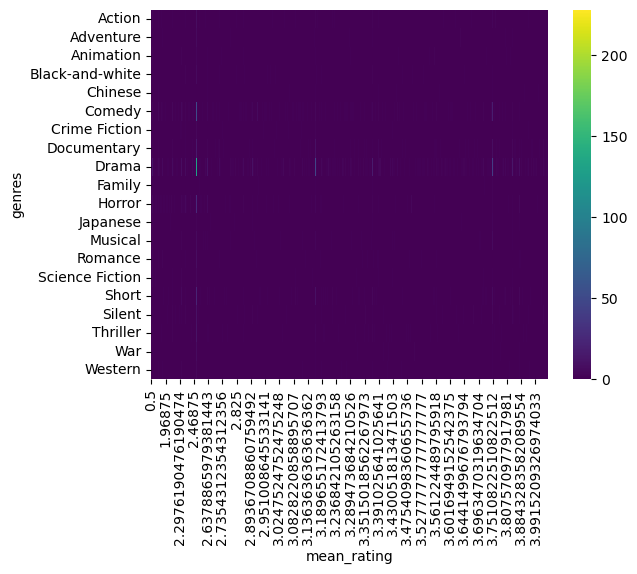

In [905]:
df_basicgenres_meanratings = pd.crosstab(df_movies_TMDB_ratings_basic['genres'],df_movies_TMDB_ratings_basic['mean_rating'])
sns.heatmap(df_basicgenres_meanratings, annot=False, cmap='viridis')

The above is hard to visualize as the mean_rating's need to be binned.

<Axes: xlabel='mean_rating_binned', ylabel='genres'>

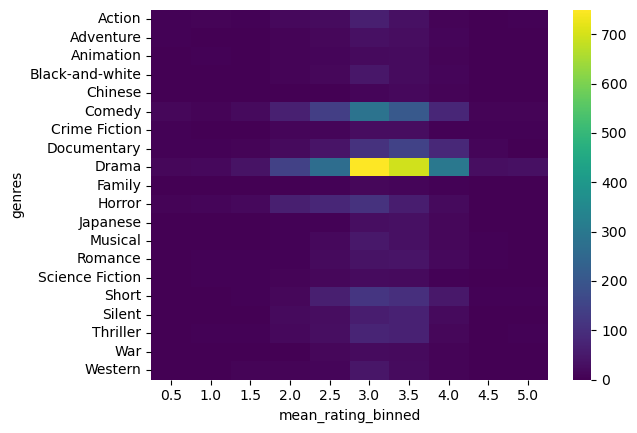

In [906]:
# rounding mean_ratings of films to the nearest half number
df_movies_TMDB_ratings_basic['mean_rating_binned'] = df_movies_TMDB_ratings_basic.mean_rating.mul(2).round().div(2)

df_basicgenres_meanratings = pd.crosstab(df_movies_TMDB_ratings_basic['genres'],df_movies_TMDB_ratings_basic['mean_rating_binned'])
sns.heatmap(df_basicgenres_meanratings, annot=False, cmap='viridis')

Feel like the mean ratings could be normalized per genre, so that the heatmap can be analyzed across genre rows.

<Axes: xlabel='mean_rating_binned', ylabel='genres'>

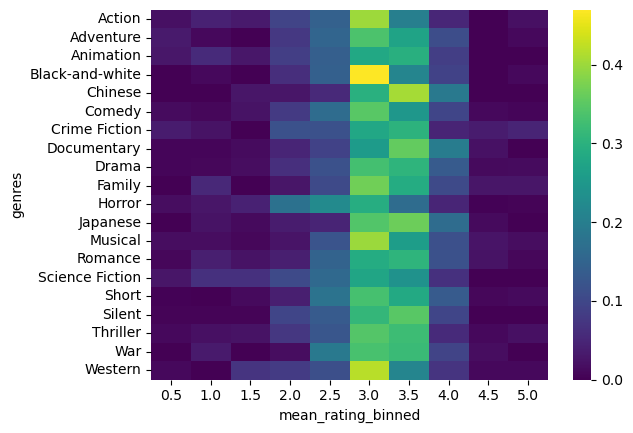

In [930]:
df_basicgenres_meanratings = pd.crosstab(df_movies_TMDB_ratings_basic['genres'],df_movies_TMDB_ratings_basic['mean_rating_binned'], normalize='index')
sns.heatmap(df_basicgenres_meanratings, annot=False, cmap='viridis')

All of the main basic genres seem to be normally distributed for their binned ratings.